In [3]:
!which python
import lightgbm as lgb
print(lgb.__version__)



/workspaces/churn/.venv/bin/python
4.6.0


[LightGBM] [Info] Number of positive: 4130, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 310
[LightGBM] [Info] Number of data points in the train set: 8260, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.543161

🔍 Custom Threshold = 0.4
              precision    recall  f1-score   support

           0       0.93      0.57      0.71      1033
           1       0.43      0.89      0.58       374

    accuracy                           0.65      1407
   macro avg       0.68      0.73      0.64      1407
weighted avg       0.80      0.65      0.67      1407



/workspaces/churn/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


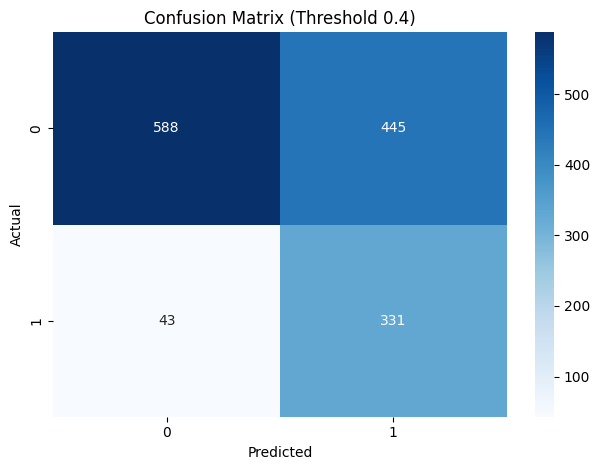

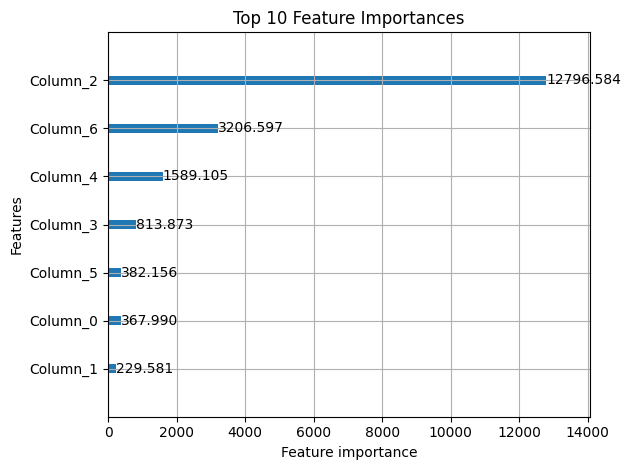

['../model/lgb_scaler.pkl']

In [ ]:
# 💼 Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 📊 Load & Clean Data
df = pd.read_csv('../data/churn.csv')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
df.drop(columns=['customerID'], inplace=True)

# 🎯 Select Features
selected = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'PhoneService', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod',
    'MonthlyCharges', 'TotalCharges', 'Churn'
]
df = df[selected]

# 🔤 Encode categorical features
for col in df.select_dtypes('object'):
    if col != 'Churn':
        df[col] = LabelEncoder().fit_transform(df[col])

# 🏷️ Encode target
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# 🔀 Train-Test Split
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ⚖️ Normalize & Balance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# 🚀 Train LightGBM Model using callback for early stopping
model = lgb.LGBMClassifier(random_state=42, n_estimators=1000)

model.fit(
    X_resampled, y_resampled,
    eval_set=[(X_test_scaled, y_test)],
    callbacks=[lgb.early_stopping(stopping_rounds=50)],
)

# 📈 Predict Probabilities & Apply Threshold
y_proba = model.predict_proba(X_test_scaled)[:, 1]
threshold = 0.4
y_pred = (y_proba >= threshold).astype(int)

# 📊 Evaluation
print(f"\n🔍 Custom Threshold = {threshold}")
print(classification_report(y_test, y_pred))

# 📉 Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Threshold 0.4)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# 🔎 Feature Importance
lgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()

# 💾 Save model & scaler
joblib.dump(model, '../model/churn_lgb_model.pkl')
joblib.dump(scaler, '../model/lgb_scaler.pkl')


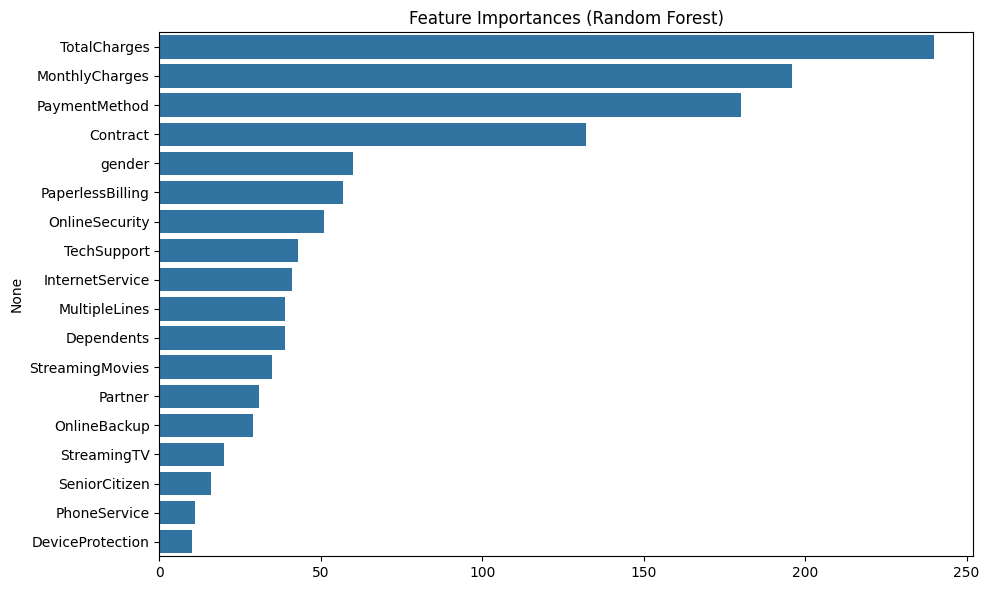

In [5]:
importances = model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title('Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()


In [6]:
import joblib
joblib.dump(model, 'churn_model.pkl')



['churn_model.pkl']

In [7]:
import joblib

# Save model and scaler
joblib.dump(model, '../model/churn_model.pkl')
joblib.dump(scaler, '../model/scaler.pkl')



['../model/scaler.pkl']